![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split

In [4]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

--- ---

In [5]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [7]:
# deducir qué estación corresponde a qué número según la temperatura
bikes.groupby('season').temp.mean()

season
1    12.530491
2    22.823483
3    28.789111
4    16.649239
Name: temp, dtype: float64

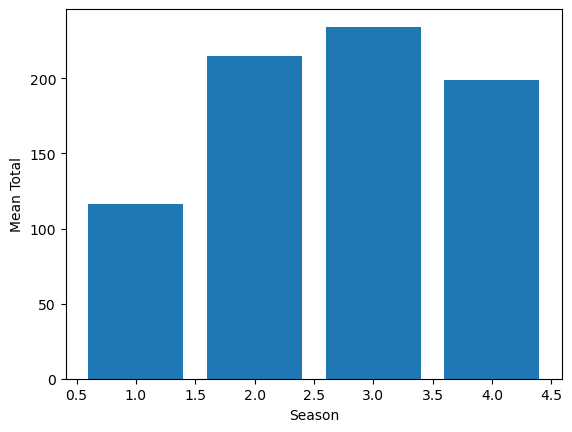

In [8]:
p1=bikes.groupby('season').total.mean()

plt.bar(p1.index, p1.values)  
plt.xlabel('Season')
plt.ylabel('Mean Total')
plt.show()

En primer lugar, se observa que la estación (`season`) con menor renta promedio de bicicletas es la 1, la cual es probablemente invierno, pues tiene también la menor temperatura promedio de las 4. El máximo de rentas promedio corresponde a la estación tres, la cual corresponde a verano, aunque con poca variación respecto a las estaciones 2 y 4. Por la baja cardinalidad de esta variable, usar métodos como `.describe()`, o diagramas de cajas, tiene poco valor, pues aporta poca información adicional a la que ya se tiene.

Respecto a la hora del día (`hour`), se observa en primer lugar poca actividad de renta entre las horas 1 y 6 y 21 y 23, y una mayor concurrencia entre las horas 6 y 20. Se procede a complementar este análisis preliminar.

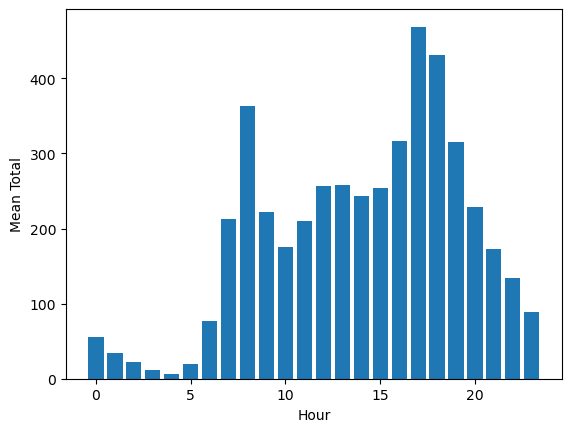

In [9]:
p2=bikes.groupby('hour').total.mean()
plt.bar(p2.index, p2.values)  
plt.xlabel('Hour')
plt.ylabel('Mean Total')
plt.show()

In [10]:
p2.describe()

count     24.000000
mean     190.742045
std      133.245822
min        6.407240
25%       70.979121
50%      211.895604
75%      256.828399
max      468.765351
Name: total, dtype: float64

Para la variable `hour`, se observa que la mayor actividad ocurre en promedio en la hora 17 del día (5 p.m.), y la mayor actividad de renta de bicicletas coincide aproximadamente con las horas laborales (8 a.m. a 6 p.m. aproximadamente). La distribución observada no sirve un patrón o distribución discernibles, y presenta dos picos, que corresponden al inicio y al final del día de trabajo, aproximadamente.

De las celdas anteriores, aparte de la información ya encontrada, puede afirmarse que no hay una interacción claramente observable entre la estación y la hora, en lo que respecta a la renta promedio de bicicletas. Es decir, para todas las estaciones, se observa un comportamiento similar de renta según la hora.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

--- ---

<Axes: xlabel='hour'>

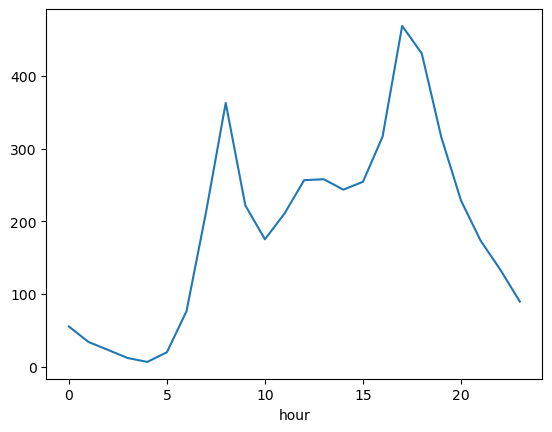

In [11]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

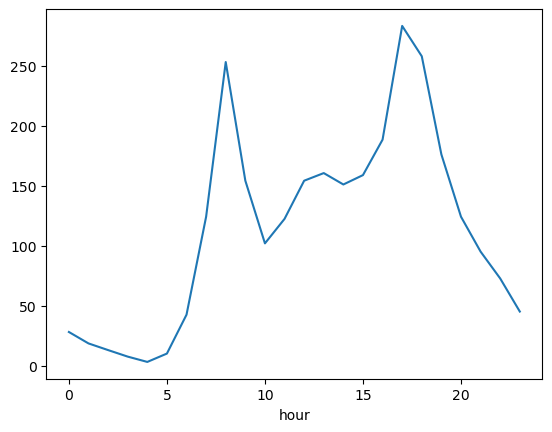

In [12]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
df_1 = bikes[bikes['season'] == 1]
df_1.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

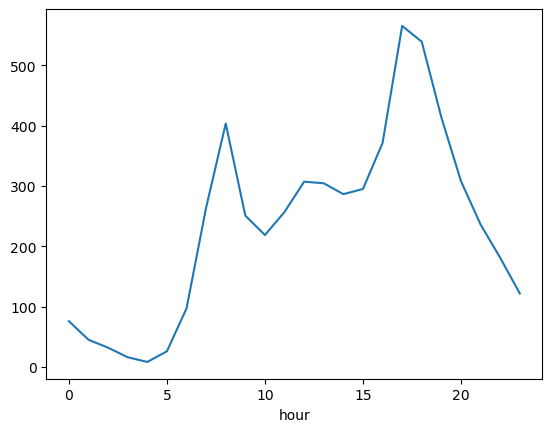

In [13]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
df_1 = bikes[bikes['season'] == 3]
df_1.groupby('hour').total.mean().plot()

Comparando las dos gráficas, se observa un comportamiento horario muy similar, si no idéntico, con la única diferencia de que la gráfica de la estación 3 tiene un desplazamiento hacia arriba respecto a la estación 1, lo cual corresponde a mayor actividad de usuarios. Esto puede confirmarse en la siguiente gráfica:

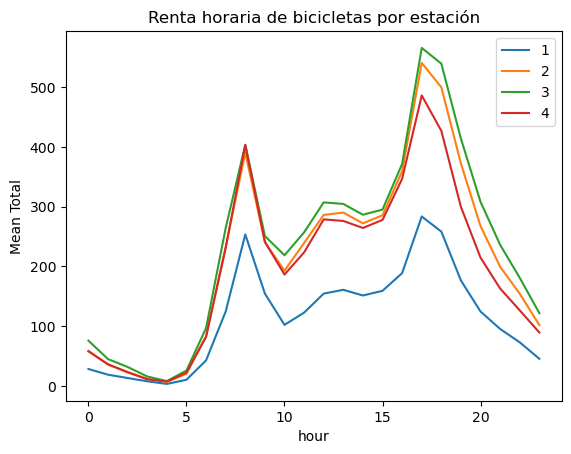

In [14]:
# https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/
# crear los datos de cada estación
estaciones=[]
for i in range (1,5):
    df= bikes[bikes['season'] == i]
    df=df.groupby('hour').total.mean()
    estaciones.append(df)
# crear la gráfica
cuenta=1
for i in estaciones:
    plt.plot(i.index, i.values, label=cuenta)
    cuenta=cuenta+1
    
plt.title("Renta horaria de bicicletas por estación")
plt.xlabel("hour")
plt.ylabel("Mean Total")
plt.legend()
plt.show()

Se observa que todas las estaciones tienen un comportamiento horario similar. La estación 1, en comparación con la 3, presenta picos mucho menos pronunciados en las horas 8 y 17, y un promedio de renta de bicicletas inferior para todo el rango horario.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

--- ---

In [15]:
# se usan todos los datos para entrenamiento
# separar las matrices x, y
y=bikes["total"]
# aplicar encoding
dummies = pd.get_dummies(bikes['season'], prefix="season")
# mapear las columnas como numericas (evita posibles problemas en la conversión)
cols=list(dummies.columns)
for i in cols:
    dummies[i]=dummies[i].astype(int)
# combinar df
x = pd.concat([bikes[['hour']], dummies], axis=1)

# crear un modelo, entrenarlo y ver su resulatdo
reg = LinearRegression().fit(x, y)
print("R2: ", reg.score(x, y))
print("\nCoeficientes: ")
cols=list(x.columns)
coefficient_pairs = zip(cols, reg.coef_)
for name, coef in coefficient_pairs:
    print(f"{name}: {coef:.4f}")



R2:  0.22339339904452493

Coeficientes: 
hour: 10.5452
season_1: -75.9670
season_2: 24.3503
season_3: 43.5006
season_4: 8.1161


La regresión lineal logra un ajuste pobre de los datos, y con las variables escogidas sólamente logra explicar el 22.3% de la variabilidad en `total`. Esto es comprensible considerando las gráficas de puntos anteriores, pues por ejemplo, para el comportamiento horario, la función real de demanda no puede ser aproximada con una recta. 

Respecto a los coeficientes, su confiabilidad es limitada, puesto que no se logró un buen ajuste sobre los datos, pero se observa que el efecto de temporada 1 sobre los datos es tener en promedio 76 rentas totales menos de bicicletas en cualquier momento del día, respecto a estar en cualquier otra estación. Los demás coeficientes para `season` tienen la misma interpretación.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

--- --- 

Para este punto, se hace uso del código presentado en los tutoriales de la semana. Por simplicidad, para asegurar los nodos finales, se usa un enfoque iterativo, con verificación manual del número de nodos, variando el parámetro `max_depth` (la profundidad máxima del árbol). También, se hace uso de las matrices `x` y `y` definidas en el punto anterior.

In [16]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y 
# punto de corte para hacer la bifurcación del árbol
# (solo un split)
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1]) # num de vars X
    # guardar datos para el mejor split
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        # crear los splits del espacio de la variable
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
            # seleccionar el mejor split posible, 
            # basado en cual otorga la mayor pérdida de impureza en los nodos finales            
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
# el código corre hasta alcanzar uno de los criterios de parada: min_gain, max_depth
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree


In [17]:
tree_grow(x, y, level=0, min_gain=0.001, max_depth=3, num_pct=2)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [0, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [0, 5.0],
  'n_samples': 3594,
  'gain': 2787.7412926245124,
  'sl': {'y_pred': 1,
   'y_prob': 26.250223813786928,
   'level': 2,
   'split': [0, 1.0],
   'n_samples': 2232,
   'gain': 426.67974276363384,
   'sl': {'y_pred': 1,
    'y_prob': 54.89934354485777,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_prob': 18.861720067453625,
    'level': 3,
    'split': -1,
    'n_samples': 1777,
    'gain': 187.3786779670263}},
  'sr': {'y_pred': 1,
   'y_prob': 103.08064516129032,
   'level': 2,
   'split': [0, 7.0],
   'n_samples': 1362,
   'gain': 12114.697055746132,
   'sl': {'y_pred': 1,
    'y_prob': 48.002200220022004,
    'level': 3,
    'split': -1,
    'n_samples': 907,
    'gain': 1595.6353253165944},
   'sr': {'y_pred': 1,
   

Para contar el número de hojas en esta estructura, se observa que la estructura del árbol son diccionarios anidados. Los nodos que tienen continuación tienen la llave split de la forma ` 'split': [a, b]`, mientras que los nodos finales tienen la llave split de la forma `'split': -1`. 

In [18]:
# solo se consideran hasta cuatro de anidación, por facilidad en el código
def contar_hojas(data):
  cuenta = 0
  # anidación 1
  for i in data.values():
    if i==-1:
      cuenta+=1
    elif isinstance(i, dict): # si el valor es un diccionario 
       # anidación 2
      for j in i.values():
        if j==-1:
          cuenta+=1
        elif isinstance(j, dict):
           # anidación 3
          for k in j.values():
            if k==-1:
              cuenta+=1
            elif isinstance(k, dict):
               # anidación 4
              for l in k.values():
                if l==-1:
                  cuenta+=1
      
  return cuenta

var= tree_grow(x, y, level=0, min_gain=0.001, max_depth=3, num_pct=2)
print("Numero de hojas : ",contar_hojas(var))

Numero de hojas :  8


Se observa que, para el código de árboles de decisión manual, usando los parámetros `level=0, min_gain=0.001, max_depth=3, num_pct=2`, se obtuvieron al menos 8 hojas, o nodos finales, lo cual cumple el requisito del enunciado.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

--- ---

In [19]:
# separar las matrices x, y
y=bikes["total"]
# aplicar encoding
dummies = pd.get_dummies(bikes['season'], prefix="season")
# mapear las columnas como numericas (evita posibles problemas en la conversión)
cols=list(dummies.columns)
for i in cols:
    dummies[i]=dummies[i].astype(int)
# combinar df
x = pd.concat([bikes[['hour']], dummies], axis=1)

# dividir datos en train y test, test es 20%
XTrain, XTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=0)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del R2 para cada valor de máxima profundidad (max_depth)
r2_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Crear un objeto de arboles de regresion, entrenarlo, predecir y guardar el MSE
    mod = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mod.fit(XTrain, yTrain)
    y_pred = mod.predict(XTest)
    #guardar el resultado de R2 del modelo
    r2_scores.append(mod.score(XTrain, yTrain))

Text(0, 0.5, 'R2')

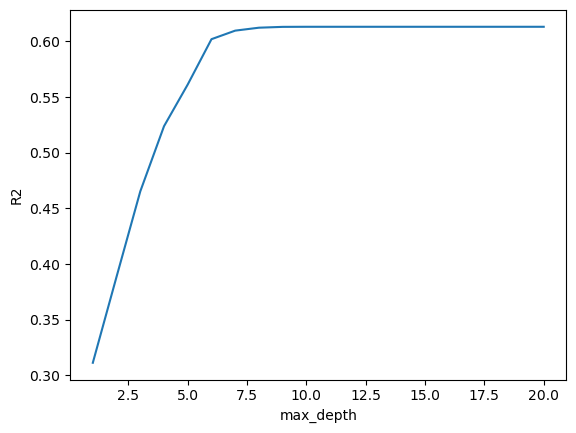

In [20]:
# Gráfica max_depth versus R2
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('R2')

Se observa que, desde una profundidad total mínima de aproximadamente 6, se logra saturar el valor R2 del modelo de árboles de regresión, con un valor de alrededor de 0.6. Esto indica que el modelo de árbol logra explicar un máximo del 60% de la variabilidad en la variable `total`. Se logra un desempeño muy superior al obtenido en el punto 3, mediante regresión lineal múltiple.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [21]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [22]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [23]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

--- ---

Se construyen los modelos por separado, sin emplear ensamblajes.

In [24]:
# librerías
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [25]:
# entrenar árboles de decisión, parámetro: max_depth
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores de accuracy y f1_score
accuracy_scores = []
f1_scores=[]

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Crear un objeto de arboles de clasificación, entrenarlo, predecir y guardar el accuracy
    mod = DecisionTreeClassifier(max_depth=depth, random_state=0)
    mod.fit(X_train, y_train)
    y_pred=mod.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))


Text(0, 0.5, 'f1-score')

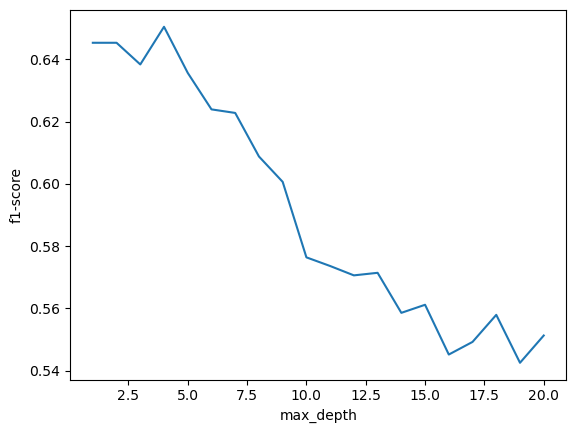

In [26]:
# Gráfica max_depth versus accuracy
plt.plot(max_depth_range, f1_scores)
plt.xlabel('max_depth')
plt.ylabel('f1-score')

Text(0, 0.5, 'accuracy')

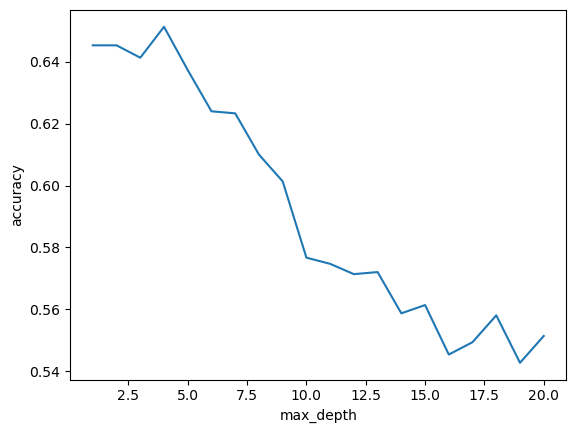

In [27]:
# Gráfica max_depth versus accuracy
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy')

Se observa que, para este caso, el accuracy y el f1-score bajan conforme aumenta el parámetro de profunidad del árbol. Esto implica que cada vez el modelo se vuelve cada vez más sobreajustado, y obtiene peores rendimientos con los datos de prueba. Se encontró que la profunidad ideal del árbol es de 4, con los siguientes parámetros:

In [28]:
print("Accuracy: ", accuracy_scores[3])
print("F1- Score: ", f1_scores[3])

Accuracy:  0.6513333333333333
F1- Score:  0.6504654088050316


In [29]:
# entrenar la regresión logística y evaluarla
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lr = LogisticRegression(random_state=0, max_iter=10000)
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
ac_lr=accuracy_score(y_test, y_pred)
f1_lr=f1_score(y_test, y_pred, average='weighted')

print("Accuracy: ", ac_lr)
print("F1- Score: ", f1_lr)

Accuracy:  0.6253333333333333
F1- Score:  0.6249553730124419


Se obtuvo que el mejor resultado del árbol de decisión con parámetro `max_depth=4` obtuvo un accuracy y F1- Score superior a la regresión logística con un parámetro `max_iter=10000`.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un ensamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 
--- ---


Por facilidad, se hace uso de las librerías de sklearn para resolver el problema. Se hace uso de la misma semilla aleatoria en todos los problemas, para asegurar que se puedan combinar. En cuanto a la votación mayoritaria, `BaggingClassifier` usa por default votación mayoritaria para resolver problemas de clasificación. Se usa el parámetro `oob_score=True` en todos los casos, pues es de utilidad en el punto 8.

In [43]:
# librerías
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [38]:
# esta celda toma alrededor de un minuto en completarse
# parte 1: 100 árboles de decisión con max_depth=4
bag_1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), n_estimators=100, random_state=42, oob_score=True)
# entrenar el modelo y predecir
bag_1.fit(X_train, y_train)
y_pred_1 = bag_1.predict(X_test)
# evaluar rendimiento
accuracy_1 = accuracy_score(y_test, y_pred_1)
f1_1=f1_score(y_test, y_pred_1)

# parte 2: 100 árboles de decisión con min_samples_leaf=3
bag_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=3), n_estimators=100, random_state=42, oob_score=True)
bag_2.fit(X_train, y_train)
y_pred_2 = bag_2.predict(X_test)
# rendimiento
accuracy_2 = accuracy_score(y_test, y_pred_2)
f1_2=f1_score(y_test, y_pred_2)

# parte 3: 100 regresiones logísticas
bag_3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, random_state=42, oob_score=True)
bag_3.fit(X_train, y_train)
y_pred_3 = bag_3.predict(X_test)
# rendimiento
accuracy_3 = accuracy_score(y_test, y_pred_3)
f1_3=f1_score(y_test, y_pred_3)

# parte 4: ensamblar los modelos juntos
# se combinan sólo las predicciones, que son equivalentes pues es el mismo X_test
# se usa votación mayoritaria manual
predicciones=[y_pred_1, y_pred_2, y_pred_3]
y_pred_4=[]
for i in range (0, len(y_pred_1)):
    total=y_pred_1[i]+y_pred_2[i]+y_pred_3[i]
    if total>=2:
        pred=1
    else:
        pred=0
    y_pred_4.append(pred)

# rendimiento
accuracy_4 = accuracy_score(y_test, y_pred_4)
f1_4=f1_score(y_test, y_pred_4)

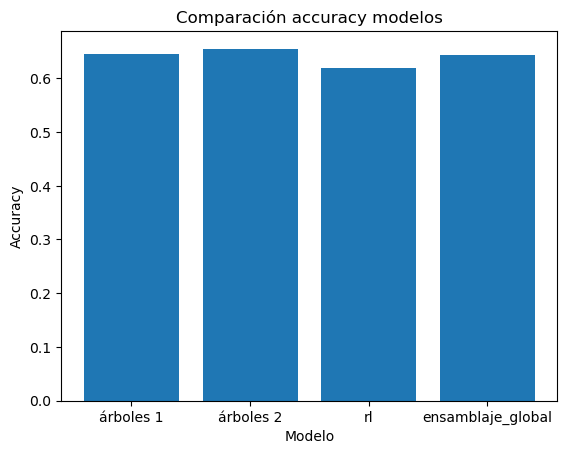

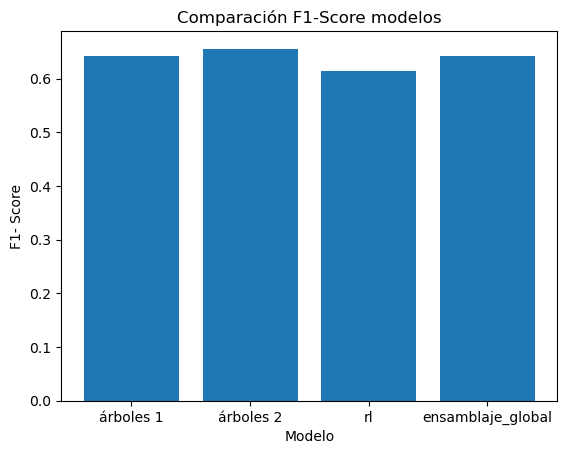

In [41]:
# graficar los resultados obtenidos

modelos = ["árboles 1", "árboles 2", "rl", "ensamblaje_global"]
accuracy_scores = [accuracy_1, accuracy_2, accuracy_3, accuracy_4]
f1_scores=[f1_1, f1_2, f1_3, f1_4]

# accuracy
plt.bar(modelos, accuracy_scores)  
plt.xlabel("Modelo")
plt.ylabel("Accuracy")
plt.title("Comparación accuracy modelos")
plt.show()

# f1-score
plt.bar(modelos, f1_scores)  
plt.xlabel("Modelo")
plt.ylabel("F1- Score")
plt.title("Comparación F1-Score modelos")
plt.show()

In [42]:
data = {'Modelo': modelos,
        'Accuracy': accuracy_scores,
        'F1-Score': f1_scores}
pd.DataFrame(data)



,Modelo,Accuracy,F1-Score
0,árboles 1,0.646000,0.641942
1,árboles 2,0.655333,0.656021
2,rl,0.619333,0.614970
3,ensamblaje_global,0.644000,0.641611


Se observa que, usando votación mayoritaria, el mejor resultado obtenido fue por los árboles usando bagging, y añadir el modelo de regresión logística al ensamblaje en realidad redujo el rendimiento global. El mejor resultado se obtuvo para `BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=3), n_estimators=100, random_state=42)`, tanto para accuracy (0.656) como para F1- Score (0.656).

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.
--- ---

Se emplea gran parte del código anterior, aprovechando la definición de los objetos clasificadores. La votación ponderada se realiza de forma manual.


In [55]:
# los ensamblajes definidos en el punto anterior
bags=[bag_1,bag_2, bag_3]
# lista para guardar las nuevas predicciones
nuevas_pred=[]

# para cada ensamblaje: 
for i in bags:
    # guardar los errores en un np.array
    errors = np.zeros(i.n_estimators)
    y_pred_all_ = np.zeros((X_test.shape[0], i.n_estimators))
    # recorrer cada estimador para cada ensamblaje
    for j in range(i.n_estimators):
        oob_sample = ~i.estimators_samples_[j]
        y_pred_ = i.estimators_[j].predict(X_train.values[oob_sample])
        errors[j] = accuracy_score(y_pred_, y_train.values[oob_sample])
        y_pred_all_[:, j] = i.estimators_[j].predict(X_test)
        
    alpha = (1 - errors) / (1 - errors).sum()
    y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(int)
    nuevas_pred.append(y_pred)

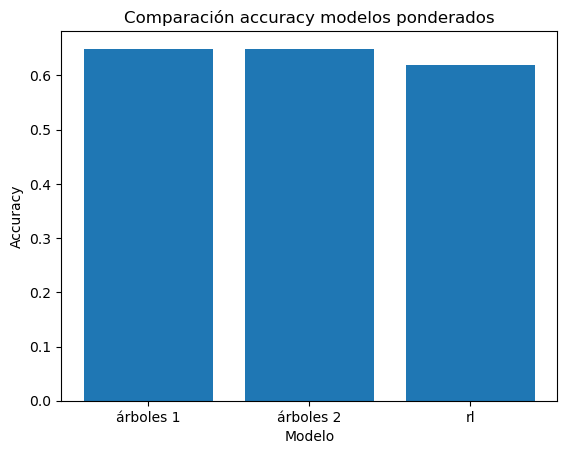

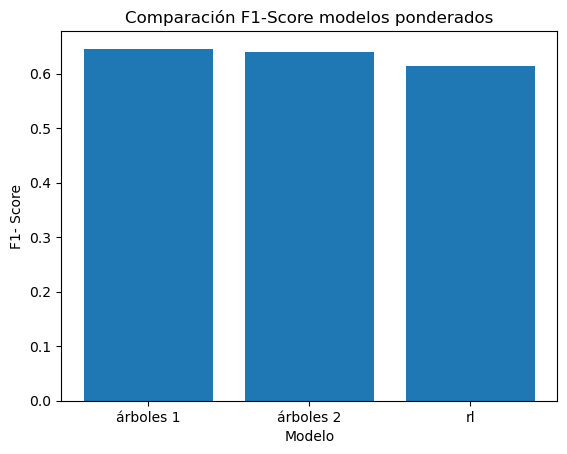

,Modelo,Accuracy,F1-Score
0,árboles 1,0.649333,0.645553
1,árboles 2,0.648667,0.640273
2,rl,0.618667,0.614555


In [78]:
# calcular las métricas
accuracy_scores_2=[]
f1_scores_2=[]
for i in nuevas_pred:
    accuracy_scores_2.append(accuracy_score(y_test, i))
    f1_scores_2.append(f1_score(y_test, i))


#graficar   
# accuracy
plt.bar(modelos[:3], accuracy_scores_2)  
plt.xlabel("Modelo")
plt.ylabel("Accuracy")
plt.title("Comparación accuracy modelos ponderados")
plt.show()

# f1-score
plt.bar(modelos[:3], f1_scores_2)  
plt.xlabel("Modelo")
plt.ylabel("F1- Score")
plt.title("Comparación F1-Score modelos ponderados")
plt.show()


data = {'Modelo': modelos[:3],
        'Accuracy': accuracy_scores_2,
        'F1-Score': f1_scores_2}
pd.DataFrame(data)

En comparación con el punto anterior, se observa que ambas métricas de rendimiento para el mejor modelo empeoraron levemente al usar votación ponderada. También, en este caso el mejor resultado corresponde al primer árbol, usando max_depth=4. 

Aunque en primer lugar no es claro por qué el modelo con votación ponderada tendría un peor rendimiento que un modelo de votación mayoritaria, esto puede deberse a que el OOB Error es calculado para los resultados de los datos de entrenamiento. Generar predicciones usando adicionalmente el OOB Error puede ocasionar un sobreajuste en los datos de entrenamiento, lo que empeora los resultados de prueba.

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.
--- ---

In [79]:
# (para poder incluir el ensamblaje total del punto 7)
accuracy_scores_2.append(0)
f1_scores_2.append(0)

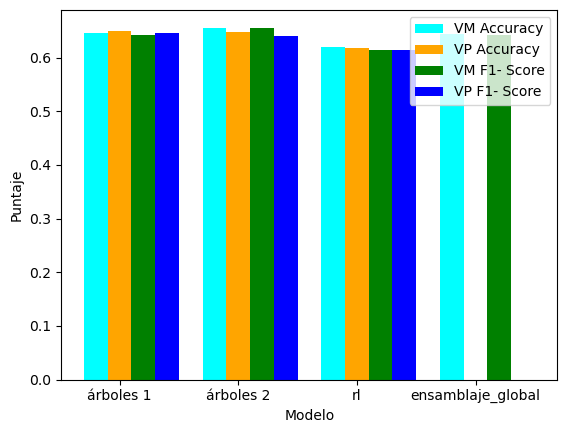

In [83]:
# https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

# graficar ambas métricas para ambos casos de votación
x=np.arange(4)
w=0.2
plt.bar(x-w, accuracy_scores, w, color='cyan') 
plt.bar(x, accuracy_scores_2, w, color='orange') 
plt.bar(x+w, f1_scores, w, color='green')
plt.bar(x+2*w, f1_scores_2, w, color='blue')  
plt.xticks(x, modelos) 
plt.xlabel("Modelo") 
plt.ylabel("Puntaje") 
plt.legend(["VM Accuracy", "VP Accuracy", "VM F1- Score", "VP F1- Score"]) 
#plt.legend(loc='upper left')
#plt.subplots_adjust(right=0.7)
plt.show()

En general, se obtuvo un rendimiento muy cercano entre todos los ensamblajes empleados. Emplear votación ponderada tuvo un efecto marginal en el rendimiento de los modelos, sólamente mejorando el modelo de ensamblaje árboles 1, que incluía como parámetro `max_depth=4`. En los otros dos casos (árboles 2 y regresión logística), usar votación ponderada redujo levemente el desempeño de los modelos. También, la regresión logística tuvo un rendimiento inferior a los dos modelos de árboles.

Los resultados de los modelos no son exhaustivos, pues no se realizó una calibración dedicada de todos sus parámetros. Sin embargo, se nota que para esta caso particular es preferible usar un ensamblaje de bagging con votación mayoritaria, pues se encontró que la votación ponderada aumenta de forma considerable la complejidad del código, sin aumentar el desempeño de los modelos de árboles.